# Mini Proyecto 1 - Reportes de actividades Bb Ultra
## Tareas Preliminares
- Lectura de archivo con información de los alumnos
- Creación de la tabla `alumnos` y carga de datos
- Generación del archivo consolidado asistencias
- Creacion de la tabla `asistencias` y carga de datos

In [2]:
import csv
import sqlite3
import os
from datetime import datetime
import matplotlib.pyplot as plt

## Lectura de archivo con informacion de los alumnos

In [3]:
data_list = []

filename = "lista_alumnos.txt"
with open(filename, encoding='utf-8') as file: 
    reader = csv.reader(file, delimiter="\t")
    print(next(reader))
    print("===================")
    print(next(reader))
    print("===================")
    for data in reader:
        data_list.append((data[0][1:11], 
                          data[2], 
                          data[1], 
                          data[3]))       
print(data_list)


[' u201510905 Menú Opciones: Nombre de usuario', 'Cesar Augusto', 'Bardales Loarte', 'u201510905@upc.edu.pe', 'Estudiante', '', 'Sí']
[' u201513319 Menú Opciones: Nombre de usuario', 'Jesus', 'Bernuy Ramirez', 'u201513319@upc.edu.pe', 'Estudiante', '', 'Sí']
[('u201621990', 'Bobadilla Chancafe', 'José Edison', 'u201621990@upc.edu.pe'), ('u201610674', 'Cachique Agreda', 'Kevin Poll Jharson', 'u201610674@upc.edu.pe'), ('u201620163', 'Cerda Flores', 'Bryan Harold', 'u201620163@upc.edu.pe'), ('u201425507', 'Garcia Guerra', 'Sebastian Elias', 'u201425507@upc.edu.pe'), ('u201719264', 'Gil Alvarado', 'Yorman Manuel', 'u201719264@upc.edu.pe'), ('u201713638', 'Koochoy Wong', 'Cecilia Sucyen', 'u201713638@upc.edu.pe'), ('u201421391', 'Ludeña Sevilla', 'Jose Luis', 'u201421391@upc.edu.pe'), ('u20151c262', 'Marquez Zapata', 'Sara Milagros', 'u20151c262@upc.edu.pe'), ('u20181e444', 'Miranda Durand', 'Fabricio Jose', 'u20181e444@upc.edu.pe'), ('u201523291', 'Molina Diaz', 'Anthony Frank', 'u20152329

## Creacion de la tabla `alumnos` y carga de datos

In [28]:
conn = sqlite3.connect("database.db")
cur = conn.cursor()

# Creacion de la tabla "alumnos"
try:
    cur.execute("DROP TABLE alumnos")
    conn.commit()
except:
    pass
   
sql = """CREATE TABLE IF NOT EXISTS alumnos 
                    (alumno_id TEXT NOT NULL PRIMARY KEY, 
                     apellido TEXT NOT NULL,
                     nombre TEXT NOT NULL, 
                     email TEXT NOT NULL)"""

cur.execute(sql)
conn.commit()

# Carga de datos a partir de la información del archivo lista_alumnos
sql = """INSERT INTO alumnos 
                (alumno_id, apellido, nombre, email) 
        VALUES  (?, ?, ?, ?)"""

cur.executemany(sql, data_list)

conn.commit()
conn.close()

## Generacion del archivo consolidado `asistencias`

In [4]:
data_asistencia = []

PATH = ".\CSV_Files"
# for items in os.listdir(PATH):
#     print(items)
    
for item in os.listdir(PATH): #Leer todos los archivos de esa ruta PATH
    if item.endswith(".csv"):
        # Lazo de lectura de todos los archivos CSV
        with open(PATH + '\\' + item, encoding='utf-8') as csv_file:
            reader = csv.reader(csv_file)
            next(reader)

            for row in reader:
                fecha = f"{row[4][6:10]}/{row[4][0:2]}/{row[4][3:5]}"
#                 print(fecha)
                row_data = (row[1], fecha, row[4][-8:], row[5][-8:], row[6], row[7])
                data_asistencia.append(row_data)
# print(data_asistencia)

In [44]:
# data_asistencia

## Creación de la tabla `asistencias` y carga de datos

In [78]:
conn = sqlite3.connect("database.db")
cur = conn.cursor()

# Creacion de la tabla "alumnos"
try:
    cur.execute("DROP TABLE asistencias")
    conn.commit()
except:
    pass
   
sql = """CREATE TABLE IF NOT EXISTS asistencias 
                    (id_registro INTEGER NOT NULL PRIMARY KEY,
                     alumno_id TEXT NOT NULL, 
                     fecha TEXT NOT NULL,
                     hora_ini TEXT NOT NULL,
                     hora_fin TEXT NOT NULL,
                     tiempo_tot TEXT NOT NULL,
                     num_conexiones INTEGER NOT NULL,
                     FOREIGN KEY (alumno_id) REFERENCES alumnos(alumno_id))"""

cur.execute(sql)
conn.commit()

# Carga de datos a partir de la información del archivo lista_alumnos
sql = """INSERT INTO asistencias 
                (alumno_id, fecha, hora_ini, hora_fin, tiempo_tot, num_conexiones) 
        VALUES  (?, ?, ?, ?, ?, ?)"""

cur.executemany(sql, data_asistencia)

sql = "DELETE FROM asistencias WHERE alumno_id = ?"
cur.execute(sql, ('pcellmun',))

conn.commit()
conn.close()

## Creacion de la clase `Database`

In [152]:
class Database:
    def __init__(self, datafile):
        self.conn = sqlite3.connect(datafile)
        self.cur = self.conn.cursor()
        
    def __del__(self):
        self.conn.close()
        
    def date_list(self, set_datetime=False):
        sql = "SELECT DISTINCT fecha FROM asistencias ORDER BY fecha"
        self.cur.execute(sql)

        fechas =  [items[0] for items in self.cur]
        
        if set_datetime:
            fechas = [datetime.strptime(fecha, "%Y/%m/%d") for fecha in fechas]
            
        return fechas
       
    def list_assistants_total(self):
        sql = "SELECT apellido FROM alumnos ORDER BY apellido"
        return [item[0] for item in self.cur.execute(sql).fetchall()]
        
    def list_assistants(self, date):
        sql = """SELECT apellido
                 FROM asistencias 
                 JOIN alumnos 
                 ON alumnos.alumno_id = asistencias.alumno_id
                 WHERE fecha = ? 
                 ORDER BY apellido
                 """
        return self.cur.execute(sql, (date,)).fetchall()        
        
    def total_assistants_date(self, date):
        sql = "SELECT COUNT(*) FROM asistencias WHERE fecha = ?"
        return self.cur.execute(sql, (date,)).fetchone()[0]
        
    
    def hours_per_student_date(self, apellido, date):
        sql = """SELECT tiempo_tot
                 FROM asistencias
                 JOIN alumnos
                 ON asistencias.alumno_id = alumnos.alumno_id
                 WHERE alumnos.apellido = ? AND asistencias.fecha = ?
        """
        time_resp = self.cur.execute(sql, (apellido, date)).fetchone()
        
        if time_resp == None:
            return 0
        else:
            hh, mm, ss = time_resp[0].split(":")
            return int(hh) * 60 + int(mm) + 1
        
    

In [151]:
dB=Database("database.db")
print(dB.hours_per_student_date("Bernuy Ramirez",'2020/08/18'))
del(dB)

[('01:55:29',)]


## Pruebas de la clase Database

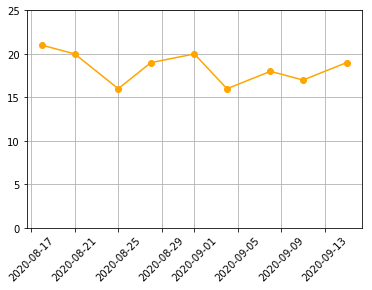

In [112]:
dB = Database("database.db")
time_vars = dB.date_list()

# print(dB.total_assistants_date("2020/08/18"))
# for date in time_vars:
#     print(date)
#     print(dB.total_assistants_date(date))
numbers = [dB.total_assistants_date(date) for date in time_vars]
time_vars = dB.date_list(set_datetime=True)

plt.plot(time_vars, numbers, '-o', color='orange')
plt.xticks(rotation=45)
plt.ylim(0, 25)
plt.grid()
plt.show()

del(dB)

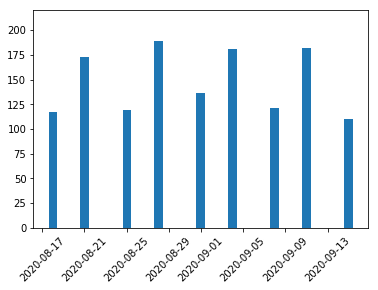

In [119]:
dB = Database("database.db")

alumno_apellido = dB.list_assistants_total()[0]

time_vars = dB.date_list()
numbers = [dB.hours_per_student_date(alumno_apellido, date) for date in time_vars]
time_vars = dB.date_list(set_datetime=True)

plt.bar(time_vars, numbers)
plt.xticks(rotation=45)
plt.ylim(0, 220)
plt.show()

del(dB)

## App tkinter

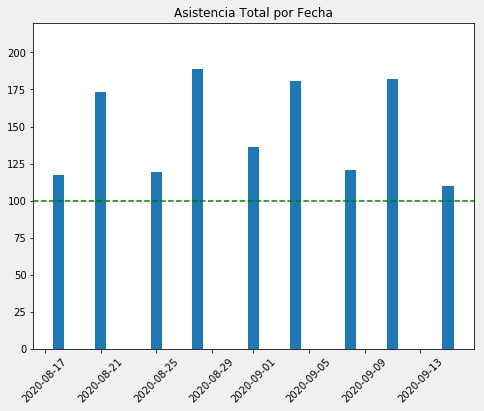

In [153]:
import tkinter as tk
import tkinter.ttk as ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter.messagebox import askokcancel

class App:
    def __init__(self, master):
        self.master = master
        self.master.resizable(0, 0)
        self.master.geometry("800x500+100+100")
        self.master.title("Reporte Asistencia Bb")
        
        # Se intercepta el boton "X" del TopLevel para permitir un cierre controlado
        # de la aplicacion
        self.master.protocol("WM_DELETE_WINDOW", self.close_app)
        
        self.dB = Database("database.db")
        
        self.var_opcion = tk.IntVar()
        
        frm = tk.Frame(self.master)
        frm.pack(padx=10, pady=10)
        
        frm1= tk.LabelFrame(frm, text="Reportes")
        frm2= tk.Frame(frm)
        
        frm1.pack(side=tk.LEFT, padx=10, pady=10)
        frm2.pack(side=tk.LEFT, padx=10, pady=10)
        
        frm1_1 = tk.Frame(frm1)
        frm1_2 = tk.Frame(frm1)
        
        frm1_1.pack(padx=5, pady=5)
        frm1_2.pack(padx=5, pady=5)
        
        # ------------------------------------------------ frm1 -----------------------------------------------
        self.rdoOpcion1 = tk.Radiobutton(frm1_1, text="Asistencia Total", 
                                         variable=self.var_opcion, value=1, command=self.graph_opcion1)
        self.rdoOpcion2 = tk.Radiobutton(frm1_1, text="Asistencia por Alumno", 
                                         variable=self.var_opcion, value=2, command=self.graph_opcion2)
        
        self.rdoOpcion1.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
        self.rdoOpcion2.grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
        
        self.scrY = tk.Scrollbar(frm1_2, orient='vertical')
        self.lstAlumnos = tk.Listbox(frm1_2, height=16, yscrollcommand=self.scrY.set)
        self.scrY.config(command=self.lstAlumnos.yview)
        
        self.lstAlumnos.pack(side=tk.LEFT)
        self.scrY.pack(side=tk.LEFT, expand=True, fill=tk.Y)
    
        for apellido in self.dB.list_assistants_total():
            self.lstAlumnos.insert(tk.END, apellido)
    
        self.lstAlumnos.bind("<<ListboxSelect>>", self.update_graph_opcion2)
        
        # ------------------------------------------------ frm2 -----------------------------------------------
        
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.fig.set_facecolor('#F0F0F0')
        
        self.graph = FigureCanvasTkAgg(self.fig, master=frm2)
        self.graph.get_tk_widget().pack()
        
        # Se definen los parametros del grafico base
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_title("Reportes")
        
        
    def graph_opcion1(self):
        # Se leen los datos de la dB
        time_vars = self.dB.date_list()
        numbers = [self.dB.total_assistants_date(date) for date in time_vars]
        time_vars = self.dB.date_list(set_datetime=True)

        # Se limpia el grafico
        self.ax.cla()
        
        # Se actualiza el grafico
        self.ax.plot(time_vars, numbers, '-o', color='orange')
        self.ax.set_title("Asistencia Total por Fecha")
        self.ax.set_ylim(0, 25)
        self.ax.xaxis.set_tick_params(rotation=45)
        self.ax.grid()
        
        self.graph.draw()
    
    
    def graph_opcion2(self):
        self.ax.cla()
        
        # Si se hace click en Opcion2, que llame a la grafica por Alumno
        # y se requiere pasar un evento, asi que le pasamos None
        self.update_graph_opcion2(None)
        
        
    def update_graph_opcion2(self, event):
        if self.var_opcion.get() == 2:
            apellido = self.lstAlumnos.get(self.lstAlumnos.curselection())

            # Se leen los datos de la dB
            time_vars = self.dB.date_list()
            numbers = [self.dB.hours_per_student_date(apellido, date) for date in time_vars]
            time_vars = self.dB.date_list(set_datetime=True)

            # Se limpia el gráfico
            self.ax.cla()

            # Se actualiza el grafico
            self.ax.bar(time_vars, numbers)
            self.ax.set_title("Asistencia Total por Fecha")
            self.ax.set_ylim(0, 220)
            self.ax.xaxis.set_tick_params(rotation=45)
            
            # Linea horizontal de referencia de 2h de clase
            self.ax.axhline(y=100, linestyle='--', color='green')
            
            self.graph.draw()
        
        
    def close_app(self):
        # Se muestre una ventana emergente que pregunta si desea salir o no (bool)
        if askokcancel("Salir", "Desea salir de la aplicacion"):
            # Se dese salir se desconecta la dB y se cierra la ventana TopLevel
            del(self.dB)
            self.master.destroy()
            
        
root = tk.Tk()
app = App(root)
root.mainloop()